In [10]:
from face_alignment.utils import transform
from scipy.ndimage.measurements import label
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import skimage.io as sio
from skimage.color import gray2rgb
from torchvision import transforms
import torch
import os
import config

In [121]:
df = pd.read_csv('../Training_Set/RFMiD_Training_Labels.csv', header=0)

In [122]:
import numpy as np
data = df.values[:,1:]
u_id = np.unique(data, axis=0)
u_id.shape

(163, 29)

In [137]:
n = 0
for i in data[:]:
    if i[7]==1 and (i.sum()==2):
        n+=1
n

23

In [124]:
c = np.zeros((data.shape[1],))
for i in data[:]:
    for j in range(i.shape[0]):
        if i[j]==1:
            c[j]+=1
c[0] = data.shape[0] - c[0]

<BarContainer object of 29 artists>

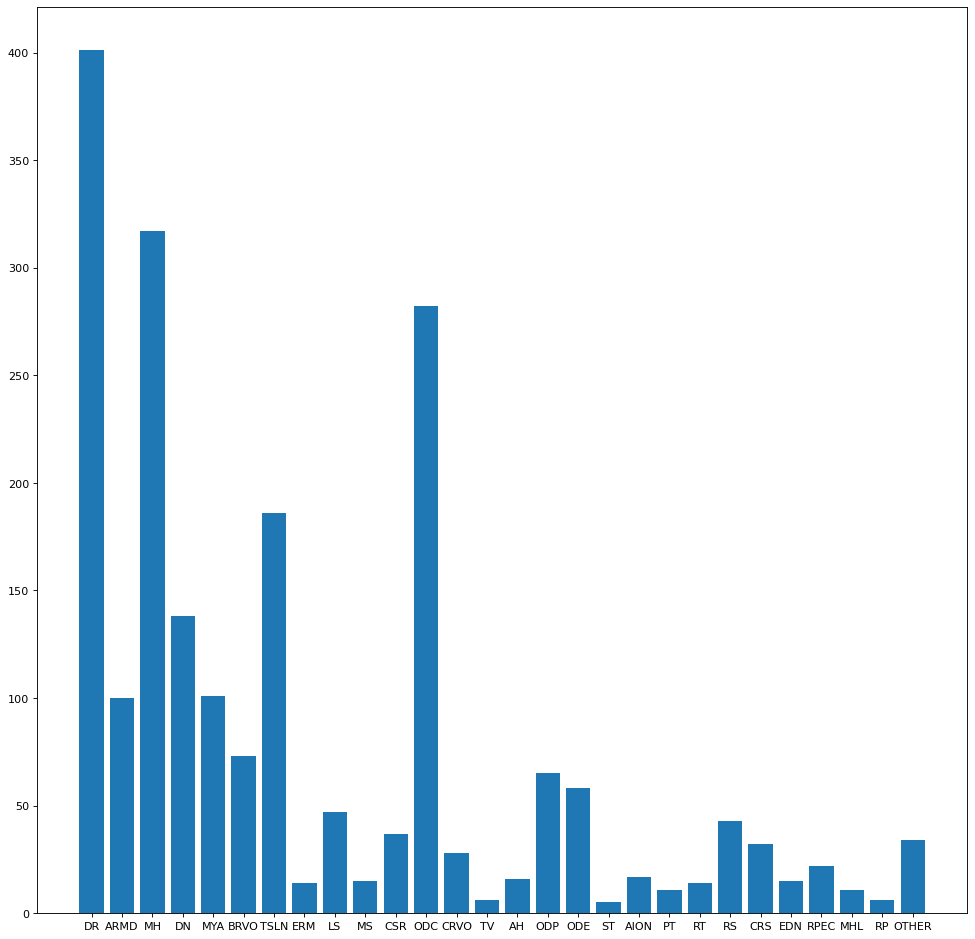

In [125]:
import matplotlib.pyplot as plt
axis_x = np.array(df.columns[1:])
axis_x[0] = 'DR'
plt.figure(figsize=(15, 15), dpi=80)
plt.bar(axis_x,c)

In [85]:
r = c[27]/np.sum(c)
1/r

411.66666666666663

In [89]:
w = np.zeros_like(c)
for i in range(w.shape[0]):
    w[i] = np.sum(c)/c[i]

In [91]:
w = w/np.min(w)
w

array([ 1.        ,  1.06648936,  4.01      ,  1.26498423,  2.9057971 ,
        3.97029703,  5.49315068,  2.15591398, 28.64285714,  8.53191489,
       26.73333333, 10.83783784,  1.42198582, 14.32142857, 66.83333333,
       25.0625    ,  6.16923077,  6.9137931 , 80.2       , 23.58823529,
       36.45454545, 28.64285714,  9.3255814 , 12.53125   , 26.73333333,
       18.22727273, 36.45454545, 66.83333333, 11.79411765])

In [97]:
label = [50,100,102]
label = torch.tensor(label).long()
print(len(label))

3


In [100]:
for i, n in enumerate(label):
    if n==100:
        print("Ah")

Ah


In [104]:
import torch.nn as nn
target = torch.ones([10, 64], dtype=torch.float32)  
output = torch.full([10, 64], 1.5)  
criterion = nn.BCEWithLogitsLoss()
loss = criterion(output, target)

In [1]:
from face_alignment.utils import transform
from scipy.ndimage.measurements import label
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import skimage.io as sio
from skimage.color import gray2rgb
from torchvision import transforms
import torch
import os
import config

In [71]:
TRAIN_TRANSFORMS = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.GaussianBlur(kernel_size=(3,3),sigma=(0.1,2)),
        #transforms.RandomHorizontalFlip(0.5),
        #transforms.RandomVerticalFlip(0.5),
        #transforms.RandomRotation(degrees=(0,45)),
        #transforms.RandomResizedCrop(size=(224,224),scale=(0.8,1.2), ratio=(0.999,1.001)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    
    ]
)

In [20]:
from scipy.stats import stats

def contrast_strech(img):
    imgori=img.copy()
    img=img.astype(np.float32)

    imgs = img.flatten()

    z = np.abs(stats.zscore(imgs))
    threshold = 2.5

    imgs = imgs[np.where(z <= threshold)]
    norm_v=(np.max(imgs) - np.min(imgs))
    if norm_v>0:
        imgnew = (img - np.min(imgs)) / norm_v
        #print (np.min(imgnew),np.max(imgnew))
        imgnew[imgnew <=0] = 0
        imgnew[imgnew >= 1] = 1
        imgnew=imgnew * 255
    else:
        imgnew=imgori
    imgnew=np.asarray(imgnew,dtype=np.uint8)
    return imgnew

In [72]:
input_image = sio.imread('../Training_Set/Training/1915.png')
#input_image = contrast_strech(input_image)
if input_image.shape[1] == 4288:
    input_image = transforms.ToPILImage()(input_image)
    input_image = transforms.functional.affine(input_image, angle=.0, scale=1,shear=0,translate = [175,0])
    input_image = transforms.CenterCrop(( 3423))(input_image) #2848,
    input_tensor = TRAIN_TRANSFORMS(input_image)
elif input_image.shape[1] == 2144:
    input_image = transforms.ToPILImage()(input_image)
    input_image = transforms.CenterCrop(1424)(input_image)
    print(type(input_image))
    input_tensor = TRAIN_TRANSFORMS(input_image)
else:
    input_image = transforms.ToPILImage()(input_image)
    input_image = transforms.CenterCrop(1536)(input_image)
    print(type(input_image))
    input_tensor = TRAIN_TRANSFORMS(input_image)

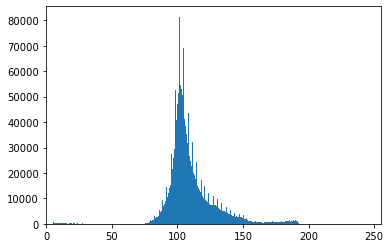

In [29]:
input_image = sio.imread('../Training_Set/Training/1.png')
vals = input_image.mean(axis=2).flatten()
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals[vals>5], 255)
plt.xlim([0,255])
plt.show()

In [50]:
vals.min()

-1.9860207

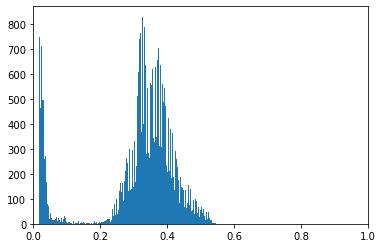

In [70]:
vals = arr.mean(axis=2).flatten()
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals[vals>0.017], 255)
plt.xlim([0,1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


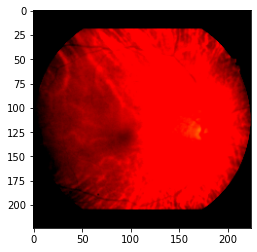

In [73]:
from  matplotlib import pyplot as plt
arr = input_tensor.numpy().transpose(1,2,0)
plt.imshow(arr)

In [5]:

import torch
import torch.nn as nn
from loss import soft_aar_loss
from metrics import *
from torchvision import models
from loss import weighted_BCEWithLogitsLoss
from nets.baseFine import BaseNet
from nets.SELayer import SELayer
from nets.resnext import ResNext

In [28]:
model = models.resnext101_32x8d(pretrained=False)
ckpt = torch.load('saved_model/ISBI-WeightedBCE-ResNext101-epoch=013-val_loss=0.0892.ckpt', map_location=torch.device('cpu'))
new_dict = {k.replace('vit.', 'model.'): v for k, v in ckpt['state_dict'].items()}

In [29]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in new_dict.items():
    name = k[6:] # remove `module.`
    new_state_dict[name] = v

In [30]:
model.fc = nn.Linear(2048, 29)
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [32]:
model.avgpool = SELayer(2048,1.5)
model.fc = nn.Linear(2048, 18)

In [33]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1